In [26]:
import heapq
import logging
import random
from itertools import chain

import matplotlib.pyplot as plt

# !pip install networkx
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout

# drawing graphs using matplotlib
from networkx.drawing.nx_pylab import draw_kamada_kawai as draw
from networkx.drawing.nx_pylab import draw_networkx
from tqdm import tqdm

from corral_crowding.bipartite import construct_bipartite_graph, plot_graphs

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

from itertools import chain

# !pip install mqt.bench
import lovelyplots
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
import scienceplots

# !pip install adjustText
# from adjustText import adjust_text
from mqt.bench import CompilerSettings, QiskitSettings, TKETSettings, get_benchmark
from qiskit import qasm2, transpile
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap
from rustworkx.visualization import graphviz_draw, mpl_draw
from tqdm.notebook import tqdm

from corral_crowding import sqiswap  # update global equivalence library
from corral_crowding.topologies import (
    build_graphs,
    corral,
    denselattice,
    hex_topo,
    ring,
    square,
    tworing,
)

In [27]:
def parse_nauty_edges(filename):
    """Parses an edge list file from nauty_gen into NetworkX graphs."""
    graphs = []

    with open(filename, "r") as file:
        for line in file:
            graph = nx.Graph()
            index, edges_str = line.strip().split(": ")
            edges = edges_str.split("; ")

            for edge in edges:
                nodes = tuple(map(int, edge.split(",")))
                graph.add_edge(*nodes)

            graphs.append(graph)

    return graphs

In [28]:
# # Example Usage
# # Parameters for the simpler prototype
# num_A = [4, 5, 6, 7, 8]  # Number of A-nodes
# m_chromatic = 3  # Number of module variants
# max_degree_A = 5  # Each A-node can connect to at most 4 B-nodes
# max_degree_B = 2  # Each B-node can connect to at most 2 A-nodes
# ###################################
# graph_list = []
# for nA in num_A:
#     graph_list.extend(parse_nauty_edges(f"../nauty_gen/connected{nA}.txt"))

# color_graphs = {}
# for g in graph_list:
#     colors = nx.coloring.greedy_color(g, strategy="random_sequential", interchange=True)
#     num_colors = len(set(colors.values()))
#     color_graphs[num_colors] = color_graphs.get(num_colors, []) + [g]

# M_colorable = color_graphs.get(m_chromatic, [])
# print(len(M_colorable))

# solution_list = []
# solution_indices = []
# planar_indices = []
# for i, g in tqdm(enumerate(M_colorable)):
#     G_rebuilt, G_A, G_B = construct_bipartite_graph(
#         g,
#         max_degree_A=max_degree_A,
#         max_degree_B=max_degree_B,
#     )
#     if G_rebuilt is not None:
#         solution_list.append((G_rebuilt, G_A, G_B))
#         solution_indices.append(i)
#         if nx.check_planarity(G_rebuilt)[0]:
#             planar_indices.append(i)

# print(f"Found {len(solution_list)} solutions")

# # check G_B that are isomorphic to any other G_B
# G_B_list = [G_B for _, _, G_B in solution_list]
# G_B_isomorphic = []
# ## XXX this can be expensive O(n^2) for large number of graphs!!!!!!!
# for i, G_B in tqdm(enumerate(G_B_list)):
#     for j, G_B2 in enumerate(G_B_list[i + 1 :]):
#         if nx.is_isomorphic(G_B, G_B2):
#             G_B_isomorphic.append((i, j))
#             break
# print(f"Found {len(G_B_isomorphic)} pairs of isomorphic G_Bs")
# print(f"Found {len(planar_indices)} planar graphs")
# planar_iter = iter(planar_indices)

In [29]:
# planar sols (m,ds,dq): 449 (4,3,3). 1668 (4,3,4), 544, (4,4,3)
# (2,3,3): 87; (2,3,2): 87; (2,2,3): 8; (2,2,2): 8

In [30]:
import networkx as nx
from tqdm import tqdm

# Parameters for the prototype
num_A = [4, 5, 6, 7, 8]  # Number of A-nodes
target_num_B = 16
m_chromatic = [2, 3]  # , 3]  # , 3]  # Number of module variants
max_degree_A_vals = [2, 3, 4, 5]  # Sweep max_degree_A values
max_degree_B = 3  # Fixed max_degree_B

# Dictionary to store solutions by (M, dS, dQ)
solutions_by_params = {}

# Load graphs
graph_list = []
for nA in num_A:
    graph_list.extend(parse_nauty_edges(f"../nauty_gen/connected{nA}.txt"))

# Categorize graphs by chromatic number
color_graphs = {}
for g in graph_list:
    colors = nx.coloring.greedy_color(g, strategy="random_sequential", interchange=True)
    num_colors = len(set(colors.values()))
    color_graphs.setdefault(num_colors, []).append(g)

# Process each M value and each max_degree_A
for m_i in m_chromatic:
    M_colorable = color_graphs.get(m_i, [])
    print(f"Found {len(M_colorable)} graphs with {m_i} colors")

    for max_degree_A in max_degree_A_vals:
        print(f"  Running with max_degree_A = {max_degree_A}")

        for i, g in tqdm(enumerate(M_colorable)):
            G_rebuilt, G_A, G_B = construct_bipartite_graph(
                g, max_degree_A=max_degree_A, max_degree_B=max_degree_B
            )

            if G_rebuilt is None or len(G_B.nodes()) < target_num_B:
                continue

            # Determine actual max degrees of G_A and G_B
            dS_actual = max(dict(G_rebuilt.degree(G_A)).values())
            dQ_actual = max(dict(G_rebuilt.degree(G_B)).values())

            # Only store if dS_actual matches max_degree_A to avoid duplicates
            if dS_actual == max_degree_A:
                key = (m_i, dS_actual, dQ_actual)
                solutions_by_params.setdefault(key, []).append((G_rebuilt, G_A, G_B))

# Checking for isomorphic graphs in each category
for key, graphs in solutions_by_params.items():
    _, _, G_B_list = zip(*graphs)  # Extract only G_B graphs
    G_B_isomorphic = []

    ## XXX This can be expensive O(n^2) for large numbers of graphs
    for i, G_B in tqdm(enumerate(G_B_list)):
        for j, G_B2 in enumerate(G_B_list[i + 1 :]):
            if nx.is_isomorphic(G_B, G_B2):
                G_B_isomorphic.append((i, j))
                break

    print(f"For (M={key[0]}, dS={key[1]}, dQ={key[2]}):")
    print(f"  Found {len(graphs)} solutions")
    print(f"  Found {len(G_B_isomorphic)} pairs of isomorphic G_Bs")


Found 251 graphs with 2 colors
  Running with max_degree_A = 2


251it [00:00, 4364.32it/s]


  Running with max_degree_A = 3


251it [00:00, 1495.91it/s]


  Running with max_degree_A = 4


251it [00:00, 872.28it/s] 


  Running with max_degree_A = 5


251it [00:00, 754.18it/s] 


Found 5386 graphs with 3 colors
  Running with max_degree_A = 2


5386it [00:02, 2475.17it/s]


  Running with max_degree_A = 3


5386it [00:05, 1003.27it/s]


  Running with max_degree_A = 4


5386it [00:07, 713.60it/s]


  Running with max_degree_A = 5


5386it [00:08, 647.20it/s]
8it [00:00, 32171.08it/s]


For (M=2, dS=2, dQ=2):
  Found 8 solutions
  Found 0 pairs of isomorphic G_Bs


89it [00:00, 1954.47it/s]


For (M=2, dS=3, dQ=2):
  Found 89 solutions
  Found 0 pairs of isomorphic G_Bs


205it [00:00, 1378.27it/s]


For (M=2, dS=4, dQ=2):
  Found 205 solutions
  Found 0 pairs of isomorphic G_Bs


229it [00:00, 1431.15it/s]


For (M=2, dS=5, dQ=2):
  Found 229 solutions
  Found 0 pairs of isomorphic G_Bs


153it [00:00, 2026.55it/s]


For (M=3, dS=2, dQ=3):
  Found 153 solutions
  Found 67 pairs of isomorphic G_Bs


2it [00:00, 46345.90it/s]


For (M=3, dS=2, dQ=2):
  Found 2 solutions
  Found 0 pairs of isomorphic G_Bs


2761it [00:23, 119.31it/s]


For (M=3, dS=3, dQ=3):
  Found 2761 solutions
  Found 405 pairs of isomorphic G_Bs


49it [00:00, 1076.17it/s]


For (M=3, dS=3, dQ=2):
  Found 49 solutions
  Found 0 pairs of isomorphic G_Bs


4885it [01:14, 65.20it/s] 


For (M=3, dS=4, dQ=3):
  Found 4885 solutions
  Found 237 pairs of isomorphic G_Bs


97it [00:00, 1570.15it/s]


For (M=3, dS=4, dQ=2):
  Found 97 solutions
  Found 0 pairs of isomorphic G_Bs


5202it [01:30, 57.17it/s] 


For (M=3, dS=5, dQ=3):
  Found 5202 solutions
  Found 117 pairs of isomorphic G_Bs


92it [00:00, 2595.29it/s]

For (M=3, dS=5, dQ=2):
  Found 92 solutions
  Found 0 pairs of isomorphic G_Bs


In [31]:
class TopologyMetric:
    def __init__(self, G):
        self.G = G

    def average_distance(self):
        """Computes the average shortest path length of a graph."""
        return nx.average_shortest_path_length(self.G)

    def graph_algebraic_connectivity(self):
        """Computes the algebraic connectivity of a graph."""
        # return nx.algebraic_connectivity(self.G)
        L = nx.laplacian_spectrum(self.G)
        return sorted(L)[1]

    def diameter(self):
        return nx.diameter(self.G)


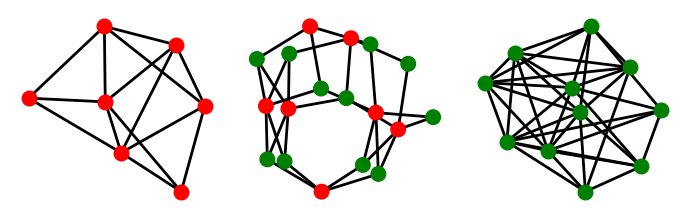

In [32]:
# Extract the set of graphs from `solutions_by_params`
graph_list = [
    (graph[0], graph[1], graph[2])
    for graphs in solutions_by_params.values()
    for graph in graphs
]

# Compute algebraic connectivity for each graph and find the highest one
best_graph1 = max(
    graph_list, key=lambda G: TopologyMetric(G[2]).graph_algebraic_connectivity()
)

plot_graphs(
    best_graph1[0],
    best_graph1[1],
    best_graph1[2],
    with_labels=False,
    filename="best.pdf",
)

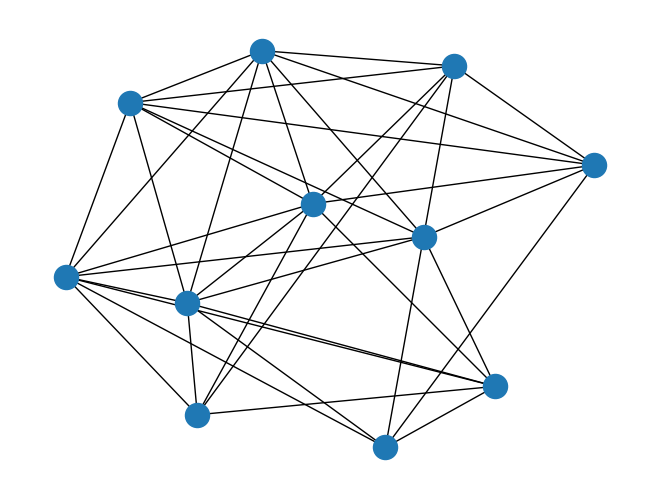

In [33]:
new_g = nx.Graph(best_graph1[2].edges())
nx.draw_kamada_kawai(new_g)

[7, 8]
[6, 8]
[5, 7]
[5, 6]


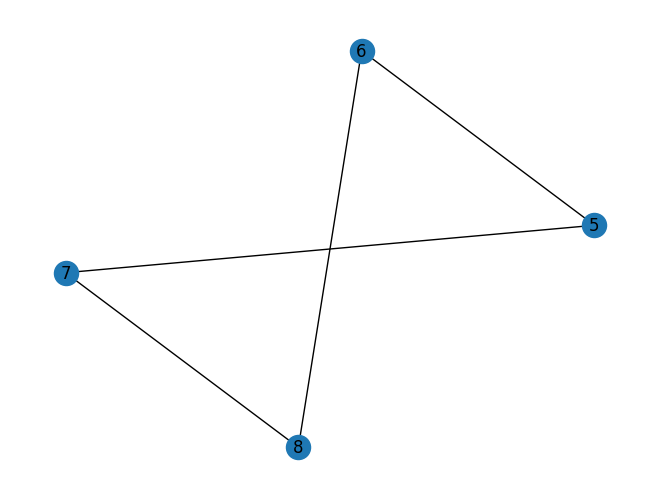

In [34]:
# Compute algebraic connectivity for each graph and find the highest one
best_graph2 = min(graph_list, key=lambda G: TopologyMetric(G[2]).diameter())

# plot_graphs(best_graph2[0], best_graph2[1], best_graph2[2])

# we need a modified construction of the qubit connectivity graph
# current I use a bipartite projection, such that every pair of qubits connected to a coupler gets an edge
# project(G, B) -> G_B
# because I know the degree of each coupler is 4, it should be creating 6 edges (4 choose 2)
# I want to only create 5 out of these 6 edges
# we can take the complete G_B, and for each node A find 1 edge to remove


def build_graphs(G, A, B):
    k = 1
    G_new = nx.Graph()
    G_new.add_nodes_from(B)
    for a in A:
        # connect all neighbors b of a to each other
        neighbors = list(G.neighbors(a))
        print(neighbors)
        idx = 0
        for i in neighbors:
            for j in neighbors:
                if i != j and i < j and idx < 6 - k:
                    G_new.add_edge(i, j)
                    idx += 1
    return G_new


g_new = build_graphs(best_graph2[0], best_graph2[1], best_graph2[2])
draw(g_new, with_labels=True)
plt.show()

[6, 7]
[7, 9]
[5, 6]
[5, 8]
[7, 8]
[6, 8]
[5, 7]
[5, 6]
[8, 9]
[9, 10]
[7, 8]
[6, 7]
[6, 11]
[10, 11]
[11, 13]
[9, 10]
[8, 9]
[7, 8]
[7, 12]
[11, 12]
[10, 12]
[9, 11]
[8, 10]
[7, 8]
[7, 9]
[12, 13]
[13, 14]
[11, 12]
[9, 10]
[10, 15]
[8, 9]
[8, 11]
[14, 15]
[15, 17]
[13, 14]
[11, 12]
[10, 12]
[9, 11]
[10, 13]
[9, 16]
[15, 16]
[14, 16]
[13, 15]
[12, 14]
[11, 12]
[10, 13]
[9, 10]
[9, 11]
[7, 8]
[5, 6, 7]
[6, 9]
[5, 10]
[6, 7, 8]
[7, 10]
[5, 6, 8]
[5, 9]
[7, 8, 9]
[6, 8, 9]
[5, 7, 10]
[5, 6, 10]
[8, 9, 10]
[9, 10, 13]
[6, 7, 8]
[7, 11]
[6, 12]
[9, 10, 11]
[8, 10, 11]
[6, 7, 9]
[7, 8, 12]
[6, 13]
[10, 11, 12]
[8, 9, 11]
[6, 7, 10]
[7, 9, 13]
[6, 8, 14]
[8, 9, 10]
[9, 12]
[7, 8, 10]
[6, 7, 11]
[6, 11, 13]
[10, 11, 12]
[9, 11, 12]
[7, 8, 10]
[9, 13]
[8, 14]
[7, 15]
[11, 12]
[9, 10, 11]
[10, 13]
[8, 14]
[7, 8, 9]
[7, 15]
[11, 12, 13]
[9, 10, 12]
[7, 8, 11]
[8, 10, 14]
[9, 15]
[7, 16]
[10, 11, 12]
[11, 12, 15]
[8, 9, 10]
[7, 9, 13]
[7, 13, 16]
[8, 14]
[10, 11, 12]
[12, 15]
[9, 11, 13]
[7, 8, 10

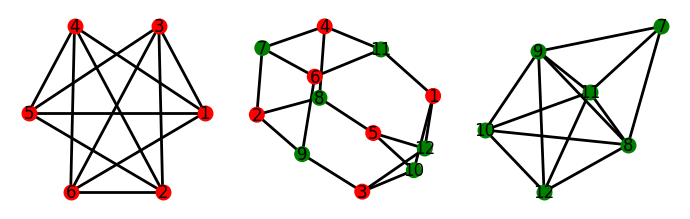

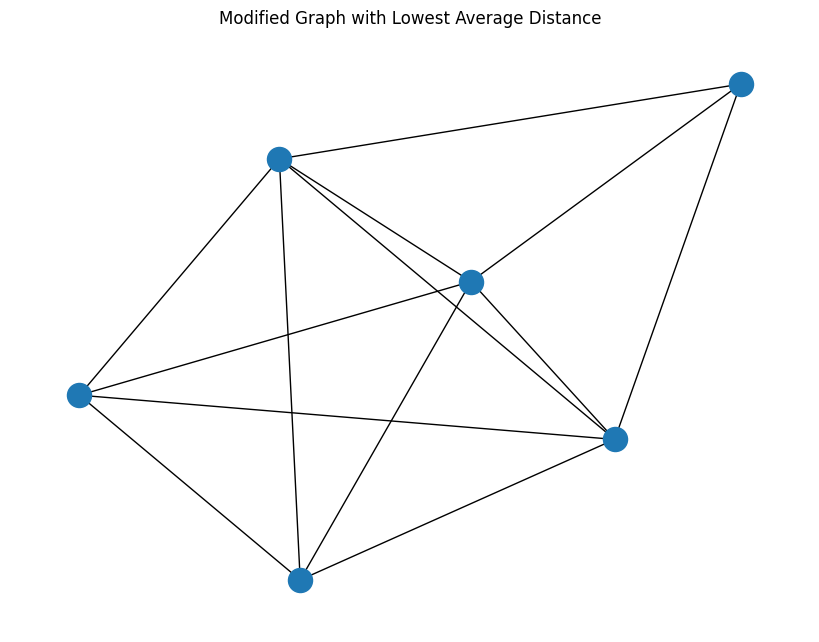

In [35]:
# Build modified graphs for all in graph_list, keeping track of their original counterparts
modified_graphs = [(build_graphs(G, A, B), G, A, B) for G, A, B in graph_list]

# Find the graph with the lowest average distance
best_modified_graph = min(
    modified_graphs, key=lambda G: TopologyMetric(G[0]).average_distance()
)

# Extract original and modified graphs
best_mod_graph, orig_graph, orig_A, orig_B = best_modified_graph

# Display the original graph
plot_graphs(orig_graph, orig_A, orig_B)

# Display the best modified graph
plt.figure(figsize=(8, 6))
draw(
    best_mod_graph,
)
plt.title("Modified Graph with Lowest Average Distance")
plt.show()

  0%|          | 0/205 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:00<00:00, 1373.12it/s]


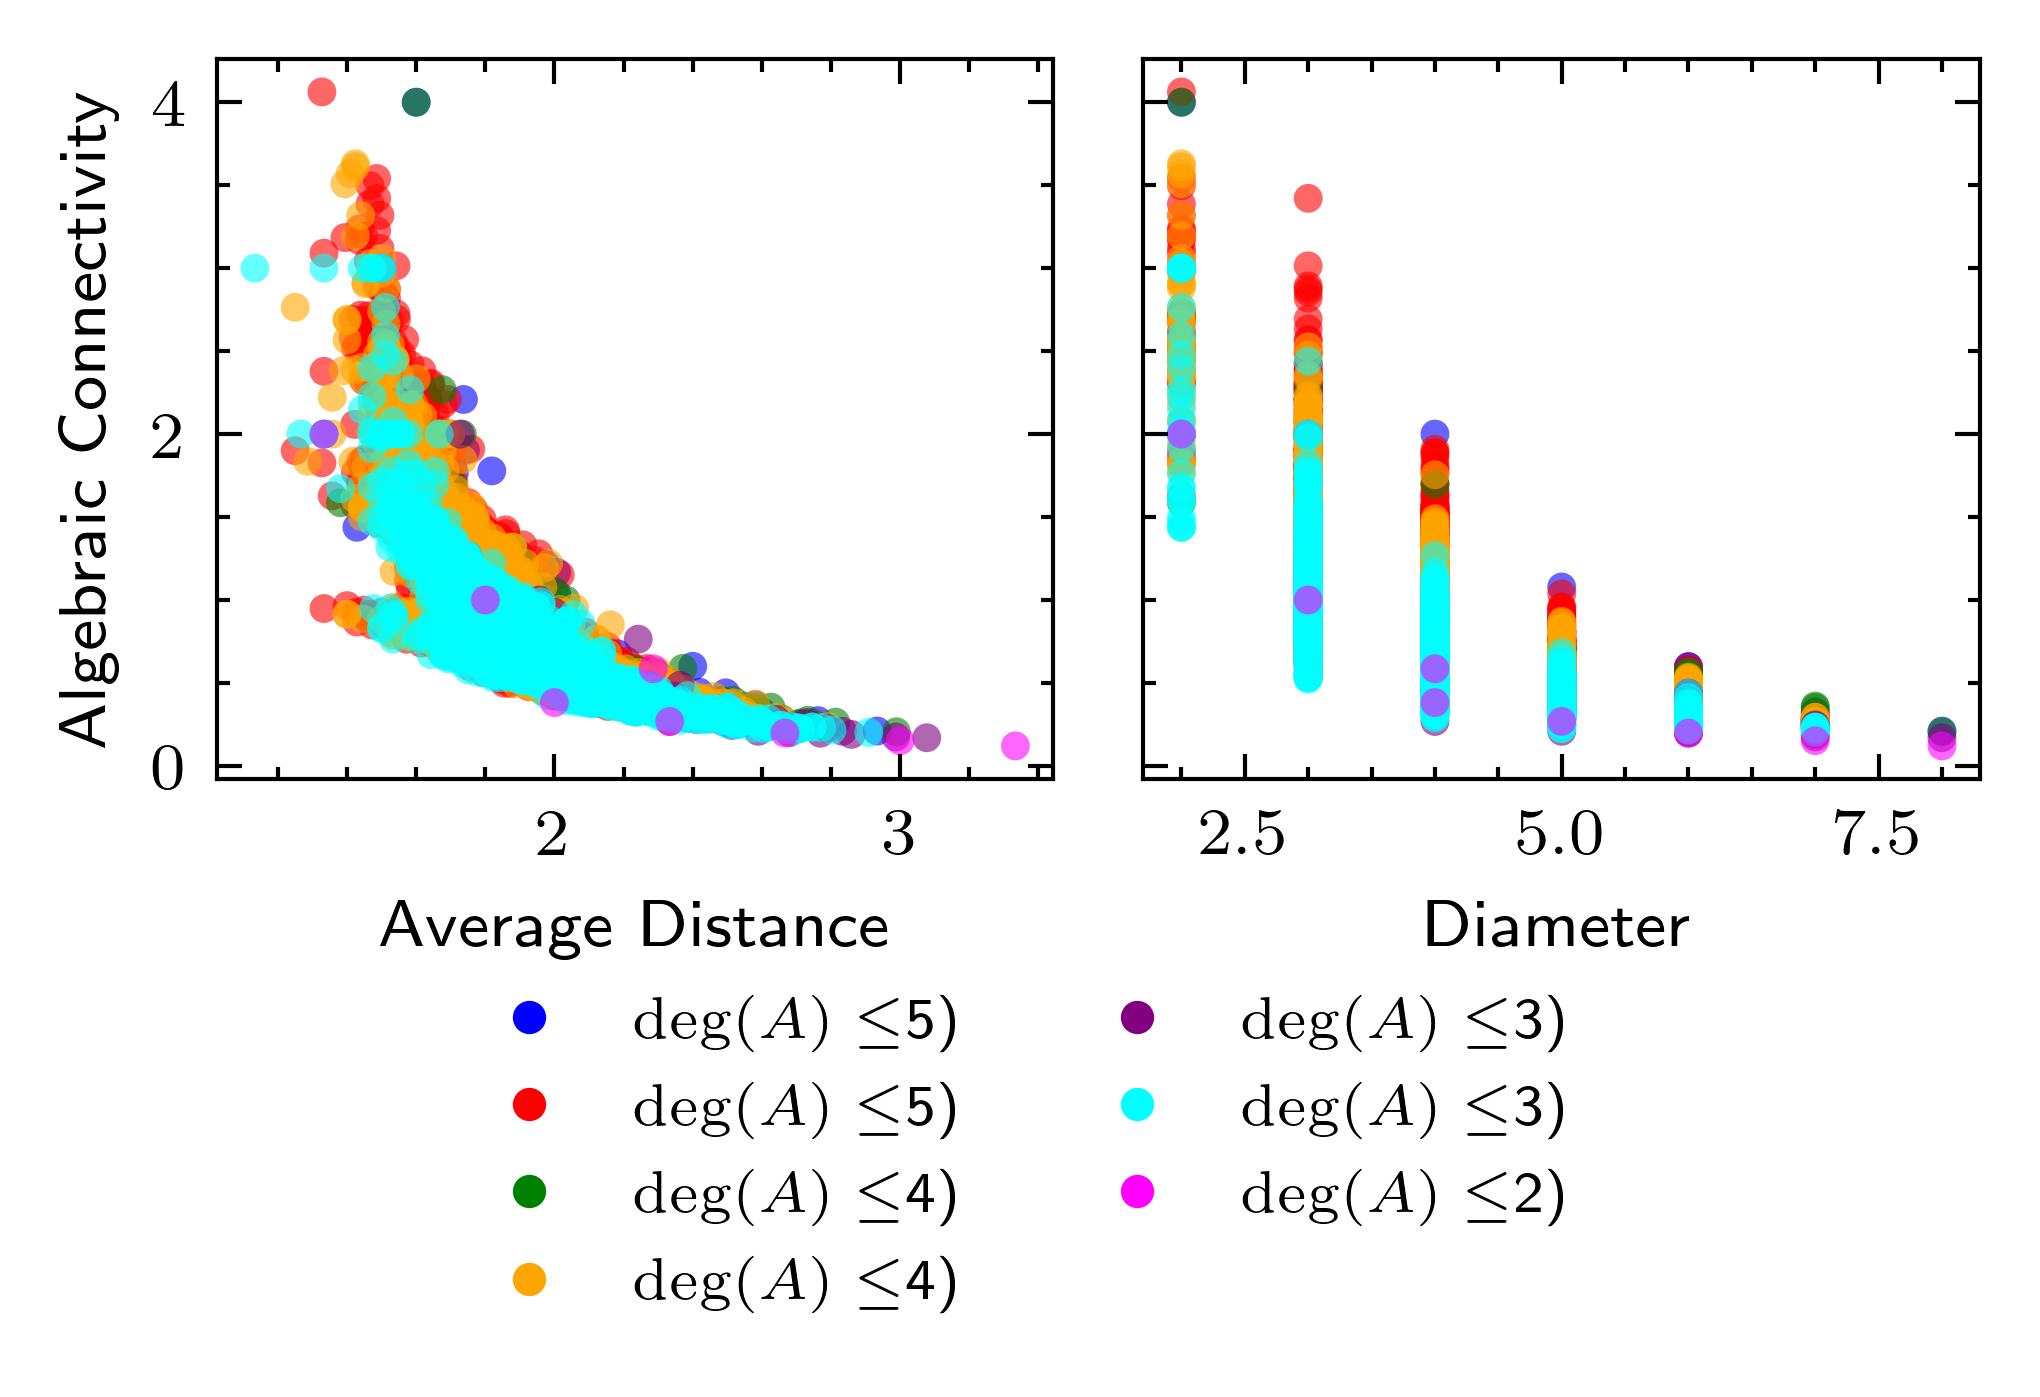

In [36]:
import matplotlib.pyplot as plt
import lovelyplots
import scienceplots
from tqdm import tqdm

# Dictionary to store (M, dS) -> (connectivity, avg_distance, diameter)
flat_results_aggregated = {}

for (M, dS, dQ), solutions in solutions_by_params.items():
    for G_rebuilt, G_A, G_B in tqdm(solutions):
        metrics = TopologyMetric(G_B)
        connectivity = metrics.graph_algebraic_connectivity()
        try:
            avg_d = metrics.average_distance()
        except Exception as e:
            print(f"Skipping (M={M}, dS={dS}) due to distance error: {e}")
            avg_d = None
        try:
            diameter = metrics.diameter()
        except Exception as e:
            print(f"Skipping (M={M}, dS={dS}) due to diameter error: {e}")
            diameter = None

        if avg_d is not None and diameter is not None:
            flat_results_aggregated.setdefault((M, dS), []).append(
                (avg_d, diameter, connectivity)
            )

# Sort keys by dS in descending order for plotting (higher-degree graphs first)
sorted_keys = sorted(flat_results_aggregated.keys(), key=lambda x: x[1], reverse=True)

# Create the figure with two side-by-side subplots
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, axes = plt.subplots(1, 2, figsize=(3.5, 1.8), sharey=True)

    colors = ["blue", "red", "green", "orange", "purple", "cyan", "magenta"]
    legend_handles = []  # Store legend handles separately

    for (M, dS), color in zip(sorted_keys, colors[: len(sorted_keys)]):
        data = flat_results_aggregated[(M, dS)]
        if data:
            avg_distances = [res[0] for res in data]
            diameters = [res[1] for res in data]
            connectivities = [res[2] for res in data]
            label = rf"($M$={M}, $\deg(A)\leq${dS})"
            label = rf"$\deg(A)\leq${dS})"

            # Plot Average Distance vs Connectivity
            scatter1 = axes[0].scatter(
                avg_distances,
                connectivities,
                color=color,
                alpha=0.6,
                s=12,
                edgecolors="none",
            )

            # Plot Diameter vs Connectivity
            scatter2 = axes[1].scatter(
                diameters,
                connectivities,
                color=color,
                alpha=0.6,
                s=12,
                edgecolors="none",
            )

            # Create legend markers with full opacity
            legend_handles.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    markerfacecolor=color,
                    markersize=5,
                    label=label,
                )
            )

    # Set axis labels
    axes[0].set_xlabel("Average Distance")
    axes[1].set_xlabel("Diameter")
    axes[0].set_ylabel("Algebraic Connectivity")  # Shared y-axis

    # Custom legend with solid markers (shared for both subplots)
    fig.legend(
        handles=legend_handles,
        ncols=2,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.1),
        fontsize=7,
    )

plt.tight_layout()
fig.savefig("topology_metrics.pdf", bbox_inches="tight")
plt.show()


  0%|          | 0/89 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:00<00:00, 1380.70it/s]


TypeError: FigureCanvasPdf.print_pdf() got an unexpected keyword argument 'rasterized'

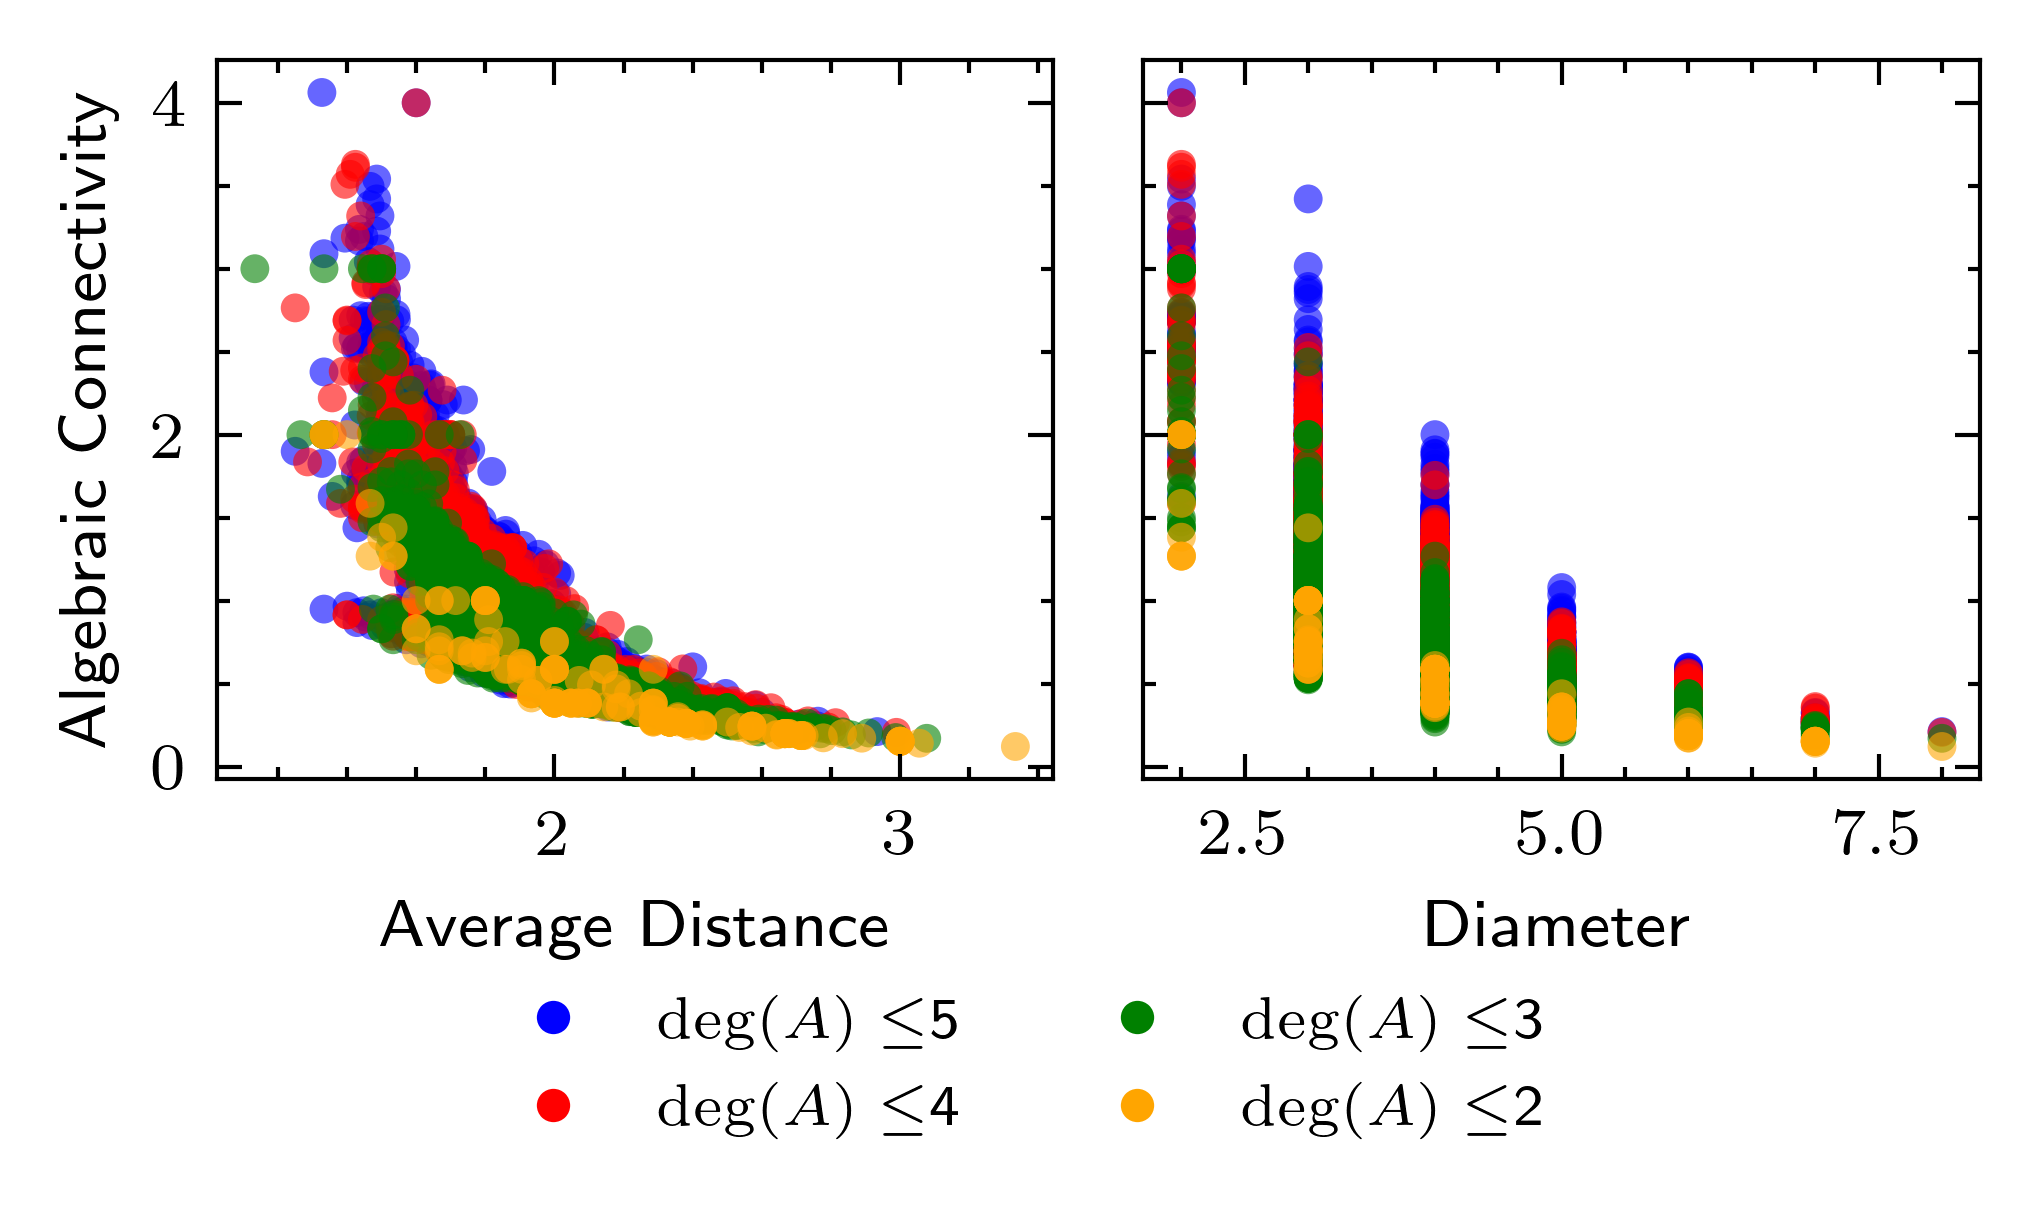

In [37]:
import matplotlib.pyplot as plt
import lovelyplots
import scienceplots
from tqdm import tqdm

# Dictionary to store dS -> (avg_distance, diameter, connectivity)
flat_results_aggregated = {}

for (M, dS, dQ), solutions in solutions_by_params.items():
    for G_rebuilt, G_A, G_B in tqdm(solutions):
        metrics = TopologyMetric(G_B)
        connectivity = metrics.graph_algebraic_connectivity()
        try:
            avg_d = metrics.average_distance()
        except Exception as e:
            print(f"Skipping (M={M}, dS={dS}) due to distance error: {e}")
            avg_d = None
        try:
            diameter = metrics.diameter()
        except Exception as e:
            print(f"Skipping (M={M}, dS={dS}) due to diameter error: {e}")
            diameter = None

        if avg_d is not None and diameter is not None:
            flat_results_aggregated.setdefault(dS, []).append(
                (avg_d, diameter, connectivity)
            )

# Sort keys by dS in descending order for plotting (higher-degree graphs first)
sorted_keys = sorted(flat_results_aggregated.keys(), reverse=True)

# Create the figure with two side-by-side subplots
with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, axes = plt.subplots(1, 2, figsize=(3.5, 1.8), sharey=True)

    colors = ["blue", "red", "green", "orange", "purple", "cyan", "magenta"]
    legend_handles = []  # Store legend handles separately

    for dS, color in zip(sorted_keys, colors[: len(sorted_keys)]):
        data = flat_results_aggregated[dS]
        if data:
            avg_distances = [res[0] for res in data]
            diameters = [res[1] for res in data]
            connectivities = [res[2] for res in data]
            label = rf"$\deg(A)\leq${dS}"

            # Plot Average Distance vs Connectivity
            scatter1 = axes[0].scatter(
                avg_distances,
                connectivities,
                color=color,
                alpha=0.6,
                s=12,
                edgecolors="none",
            )

            # Plot Diameter vs Connectivity
            scatter2 = axes[1].scatter(
                diameters,
                connectivities,
                color=color,
                alpha=0.6,
                s=12,
                edgecolors="none",
            )

            # Create legend markers with full opacity
            legend_handles.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    markerfacecolor=color,
                    markersize=5,
                    label=label,
                )
            )

    # Set axis labels
    axes[0].set_xlabel("Average Distance")
    axes[1].set_xlabel("Diameter")
    axes[0].set_ylabel("Algebraic Connectivity")  # Shared y-axis

    # Custom legend with solid markers (shared for both subplots)
    fig.legend(
        handles=legend_handles,
        ncols=2,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.1),
        fontsize=7,
    )

plt.tight_layout()
fig.savefig("topology_metrics.pdf", bbox_inches="tight", rasterized=True)
plt.show()


Compare Against SWAP Overhead: Use a small benchmark transpilation study to see if highly connected architectures translate into reduced qubit movement. ??
goal: extract why certain structures are preferable and what general principles apply to future superconducting quantum hardware.